In [1]:
from prototype import simulate_from_demography
import msprime
from dismal.multimodel import MultiModel
from dismal.models import im
import demesdraw
import demes
import prototype
import numpy as np
from scipy import stats
from quantile_forest import RandomForestQuantileRegressor
import tqdm

## Without recombinatino

In [2]:
# build msprime demography
demography = msprime.Demography()
demography.add_population(name="anc", initial_size=100_000)
demography.add_population(name="A", initial_size=200_000)
demography.add_population(name="B", initial_size=50_000)
demography.add_population_split(time=200_000, ancestral="anc", derived=["A", "B"])
demography.set_migration_rate(source="B", dest="A", rate=1e-5)
demography.set_migration_rate(source="A", dest="B", rate=4e-5)
demesgraph = demography.to_demes()

<Axes: ylabel='time ago (generations)'>

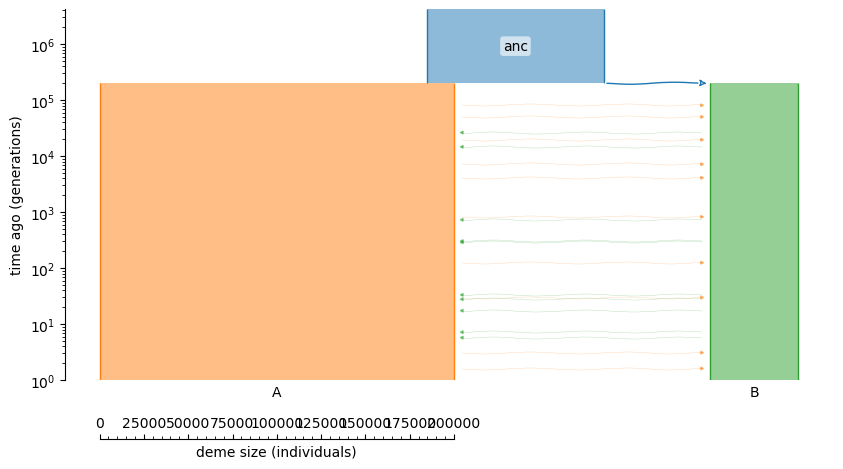

In [3]:
demesdraw.tubes(demesgraph, log_time=True, scale_bar=True)

In [4]:
blocklen = 500
num_blocks_per_state=[5000, 5000, 25000]
sparseS = simulate_from_demography(demography, blocklen=blocklen, mutation_rate=2e-8, recombination_rate=0, num_blocks_per_state=num_blocks_per_state)
S = sparseS.todense()[0]

In [5]:
s1 = S[0:blocklen]
s2 = S[blocklen:(blocklen*2)]
s3 = S[(blocklen*2):]

In [6]:
mod = im().fit_model(s1=s1, s2=s2, s3=s3)

In [7]:
mod.inferred_params

array([3.65304479, 1.06322938, 1.95174515, 4.92088385, 4.16255908,
       0.94629858])

<Axes: ylabel='time ago (generations)'>

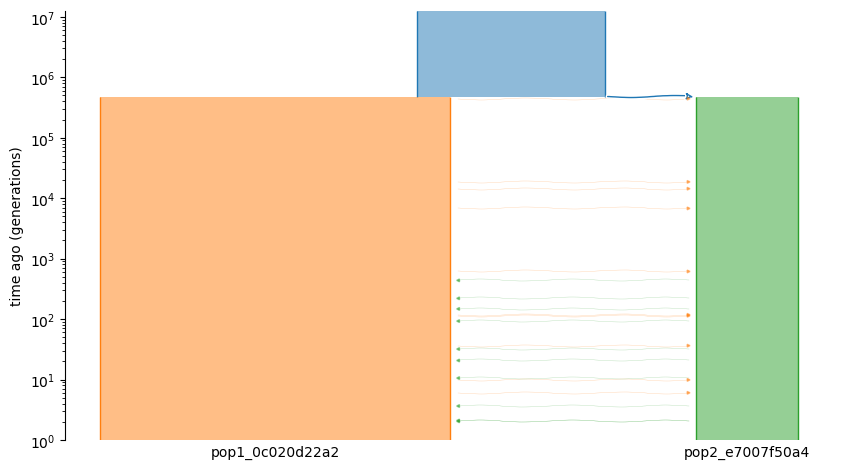

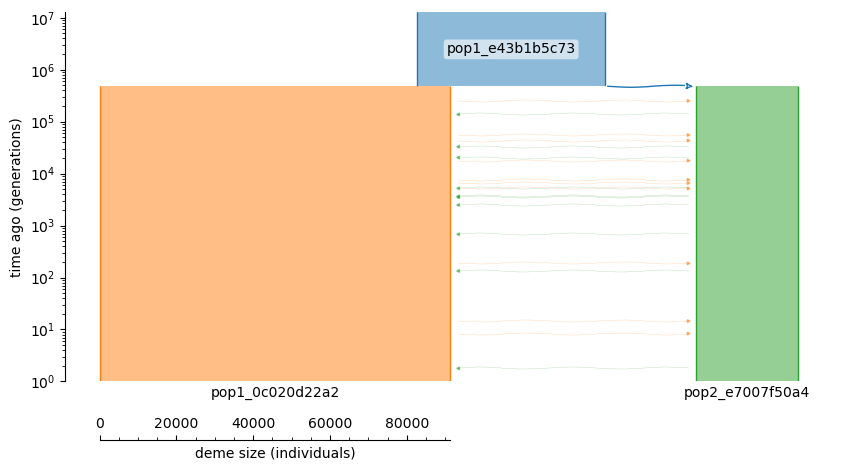

In [8]:
demesdraw.tubes(mod.demes_format(mutation_rate=2e-8, blocklen=blocklen).graph, log_time=True, scale_bar=True)

In [9]:
[deme.epochs[0].start_size for deme in mod.demes_representation.graph.demes]

[48793.62866491227, 91326.11964357803, 26580.734578245323]

In [10]:
[deme.epochs[0].start_time for deme in mod.demes_representation.graph.demes]

[inf, 480215.55832080496, 480215.55832080496]

In [11]:
mod.inferred_params

array([3.65304479, 1.06322938, 1.95174515, 4.92088385, 4.16255908,
       0.94629858])

In [12]:
def expon_prior(lmbda, n):
    return stats.expon.rvs(loc=0, scale=1/lmbda, size=n)

## Define priors

In [13]:
def M_prior(n):
    return expon_prior(0.15, n)

def popsize_prior(n):
    return expon_prior(5e-6, n)

def time_prior(n):
    return expon_prior(8e-6, n)

## Generate embeddings

In [15]:
prototype.generate_reference_embeddings(blocklen=blocklen, mutation_rate=2e-8, recombination_rate=0, num_blocks_per_state=num_blocks_per_state,
                             popsizes_prior=popsize_prior, times_prior=time_prior, M_prior=M_prior,
                             num_sims_per_mod=50_000,
                             threads=-1, save_as="simple_im_embeddings_50Ksims")

Generating 50000 embeddings of 35000 blocks for models ['iso_2epoch', 'im'] using 7 threads
Model: iso_2epoch (1/2)


100%|██████████| 50000/50000 [15:03:25<00:00,  1.08s/it]  


Model: im (2/2)


100%|██████████| 50000/50000 [15:19:49<00:00,  1.10s/it]  


(array([[3021., 1138.,  432., ...,    0.,    0.,    0.],
        [ 665.,  764.,  899., ...,    0.,    0.,    0.],
        [ 408.,  370.,  406., ...,    0.,    0.,    0.],
        ...,
        [1954., 1187.,  688., ...,    0.,    0.,    0.],
        [3503., 1015.,  320., ...,    0.,    0.,    0.],
        [4276.,   99.,   23., ...,    0.,    0.,    0.]]),
 array([[  32060.56500852,  355127.63468171,  417492.7390855 ,
           98907.0125258 ,       0.        ,       0.        ],
        [ 391391.16838277,  164634.57061441,   80321.47740557,
          117231.4770709 ,       0.        ,       0.        ],
        [ 541853.25070246,  237230.9180553 ,  414236.12536754,
          189381.85050845,       0.        ,       0.        ],
        ...,
        [  76899.41541432,  129623.71547408, 1322871.59315465,
          177559.63862849,      10.52197989,       0.01006521],
        [  21193.29221266,  529377.31320842,   31971.36540179,
           38935.26425487,       4.08823602,       0.558824

### Train model
Consider quantile-forest for future use; can also then use this for posterior estimation

In [16]:
arr = np.load("simple_im_embeddings_50Ksims.npz", allow_pickle=True)
X = arr["X"]
y = arr["y_params"]

In [17]:
X = np.vstack([x.todense() for x in X])

In [18]:
rfqr = RandomForestQuantileRegressor(n_estimators=500,
                              default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              min_samples_leaf=5,
                              max_features="sqrt",
                              n_jobs=7)

rfqr.fit(X, y)

RandomForestQuantileRegressor(default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              max_features='sqrt', min_samples_leaf=5,
                              n_estimators=500, n_jobs=7)

## Simulate test data from model

In [19]:
sims = [prototype.simulate_from_demography(demography,
                                   blocklen=blocklen,
                                   mutation_rate=2e-8,
                                   recombination_rate=0,
                                   num_blocks_per_state=num_blocks_per_state) for _ in tqdm.tqdm(range(10))]

100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


In [20]:
X_pred = np.vstack([sim.todense() for sim in sims])

In [21]:
np.mean(rfqr.predict(X_pred), axis=0)

array([[ 73555.24544111, 135049.30871079, 239258.07731872,
        384914.09646208, 581856.07373742],
       [ 22551.94698407,  41390.94887436,  62888.8751743 ,
         95518.62141449, 188891.21118794],
       [ 60051.58154999,  81363.36395508,  92490.08081384,
        103601.12561881, 129862.13647384],
       [ 10063.63398193,  21286.78431467,  47191.50152762,
        125422.98367856, 257465.56120707],
       [     0.        ,      0.        ,      1.4117416 ,
             4.92693624,     10.5353733 ],
       [     0.        ,      0.        ,      2.0161224 ,
             6.04221553,     11.56883157]])

In [25]:
2.0161224/62888

3.2058936522070984e-05

In [28]:
# build msprime demography
inferred_demography = msprime.Demography()
inferred_demography.add_population(name="anc", initial_size=92490)
inferred_demography.add_population(name="A", initial_size=239258)
inferred_demography.add_population(name="B", initial_size=62888)
inferred_demography.add_population_split(time=47191, ancestral="anc", derived=["A", "B"])
inferred_demography.set_migration_rate(source="B", dest="A", rate=5.9e-6)
inferred_demography.set_migration_rate(source="A", dest="B", rate=3.2e-5)
demesgraph = inferred_demography.to_demes()

<Axes: ylabel='time ago (generations)'>

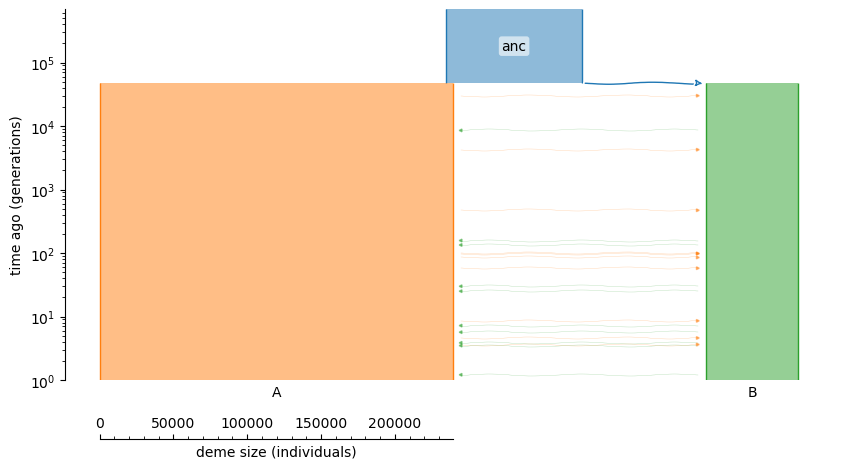

In [32]:
demesdraw.tubes(demesgraph, log_time=True, scale_bar=True)

## Does estimating parameters separately actually improve prediction?

Good test case: can we get better predictions of split time?


In [33]:
y[:, 3]

array([ 98907.0125258 , 117231.4770709 , 189381.85050845, ...,
       177559.63862849,  38935.26425487,   2358.41397567])

In [34]:
rfqr_split = RandomForestQuantileRegressor(n_estimators=500,
                              default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              min_samples_leaf=5,
                              max_features="sqrt",
                              n_jobs=7)

rfqr_split.fit(X, y[:,3])

RandomForestQuantileRegressor(default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              max_features='sqrt', min_samples_leaf=5,
                              n_estimators=500, n_jobs=7)

In [35]:
np.mean(rfqr_split.predict(X_pred), axis=0)

array([  8794.15078645,  19336.02110721,  48806.30825809, 117359.44818972,
       257262.90822493])

That actually made predictions slightly worse